In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import ipywidgets as ipw
import torch
import time
from mpl_toolkits.mplot3d import Axes3D

import programs.NN as NN
import programs.misc as misc
import programs.objects as obj 

from programs.main import *
from programs.misc import *
from programs.visualize import *

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device='cpu'
torch.cuda.set_device(device)
print(device)

cuda:0


In [3]:
path = 'data/Morlet'
net = Poisson_Convection.load(path)
net.model

Net(
  (layers): Sequential(
    (input): Linear(in_features=3, out_features=128, bias=True)
    (input_activation): Morlet()
    (hidden_0): Linear(in_features=128, out_features=128, bias=True)
    (activation_0): Morlet()
    (hidden_1): Linear(in_features=128, out_features=128, bias=True)
    (activation_1): Morlet()
    (hidden_2): Linear(in_features=128, out_features=128, bias=True)
    (activation_2): Morlet()
    (output): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [4]:
for i in range(4):
    net.make_distributed_points()

0.0012632686411961913 63485


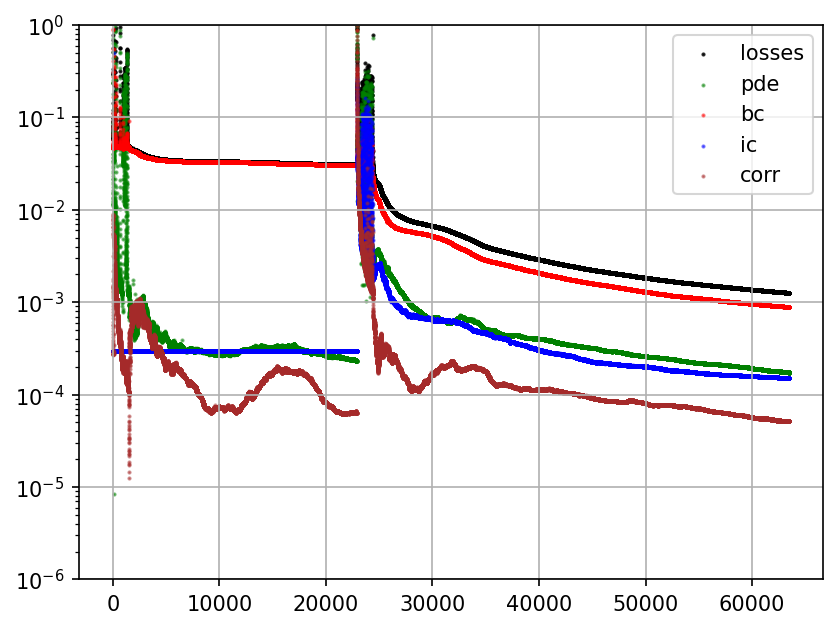

In [5]:
print (net.losses[-1], len(net.losses))
fig = plt.figure(dpi=150)
plt.scatter(range(0,len(net.losses)), net.losses,label='losses', c='black',alpha=0.8, s=1)
plt.scatter(range(0,len(net.PDE)), net.PDE,label='pde', c='green',alpha=0.5, s=1)
plt.scatter(range(0,len(net.BC)), net.BC, label='bc', c='red',alpha=0.5, s=1)
plt.scatter(range(0,len(net.IC)), net.IC, label='ic', c='blue',alpha=0.5, s=1)
plt.scatter(range(0,len(net.corr)), net.corr, label='corr', c='brown',alpha=0.5, s=1)
plt.legend(loc='upper right')
plt.grid()
# plt.savefig("gifs/losses")
plt.ylim(1e-6,1)
plt.yscale('log')

In [6]:
Nx = 101
Ny = 101
Nt = 101

t_end = 1

x_Tensor = torch.linspace(net.size[0], net.size[1], Nx)
y_Tensor = torch.linspace(net.size[2], net.size[3], Ny)
t_Tensor = torch.linspace(net.size[4], t_end, Nt)
# x_Tensor = torch.linspace(-1, 2, Nx).to(device)
# y_Tensor = torch.linspace(-1, 2, Ny).to(device)
# t_Tensor = torch.Tensor([1]).to(device)

x = np.linspace(net.size[0], net.size[1], Nx)
y = np.linspace(net.size[2], net.size[3], Ny)
t = np.linspace(net.size[4], net.size[5], Nt)

mesh_xy, mesh_yx = np.meshgrid(x,y, indexing='ij')
mesh_ty, mesh_yt = np.meshgrid(t,y, indexing='ij')

mesh_XYT = torch.stack(torch.meshgrid(x_Tensor,y_Tensor,t_Tensor, indexing='ij')).reshape(3, -1).T
mesh_X = mesh_XYT[:,0]
mesh_Y = mesh_XYT[:,1]
mesh_T = mesh_XYT[:,2]

In [7]:
net.eval()

c, px, py, ux, uy, mu, conv, div, corr = [], [], [], [], [], [], [], [], []

for i in t_Tensor:
    mesh_XYT = torch.stack(torch.meshgrid(x_Tensor,y_Tensor,i, indexing='ij')).reshape(3, -1).T
    X = torch.autograd.Variable(mesh_XYT[:,0], requires_grad=True)
    Y = torch.autograd.Variable(mesh_XYT[:,1], requires_grad=True)
    T = torch.autograd.Variable(mesh_XYT[:,2], requires_grad=True)

    c.append(net.get_c(X,Y,T).reshape(Nx, Ny).transpose(1,0))
    px.append(net.get_px(X,Y,T).reshape(Nx, Ny).transpose(1,0))
    py.append(net.get_py(X,Y,T).reshape(Nx, Ny).transpose(1,0))
    ux.append(net.get_ux(X,Y,T).reshape(Nx, Ny).transpose(1,0))
    uy.append(net.get_uy(X,Y,T).reshape(Nx, Ny).transpose(1,0))
    conv.append(net.get_conv(X,Y,T).reshape(Nx, Ny).transpose(1,0) / (net.w_func(X,Y).max()**3).data.cpu().numpy())
    div.append(net.get_div(X,Y,T).reshape(Nx, Ny).transpose(1,0) / (net.w_func(X,Y).max()**3).data.cpu().numpy())
    corr.append(net.get_corr(X,Y,T).reshape(Nx, Ny).transpose(1,0))

c = np.array(c)
px = np.array(px)
py = np.array(py)
ux = np.array(ux)
uy = np.array(uy)
conv = np.array(conv)
div = np.array(div)
corr = np.array(corr)
total = net.weights[0]*np.abs(conv) + net.weights[1]*np.abs(div) + net.weights[2]*np.abs(corr)

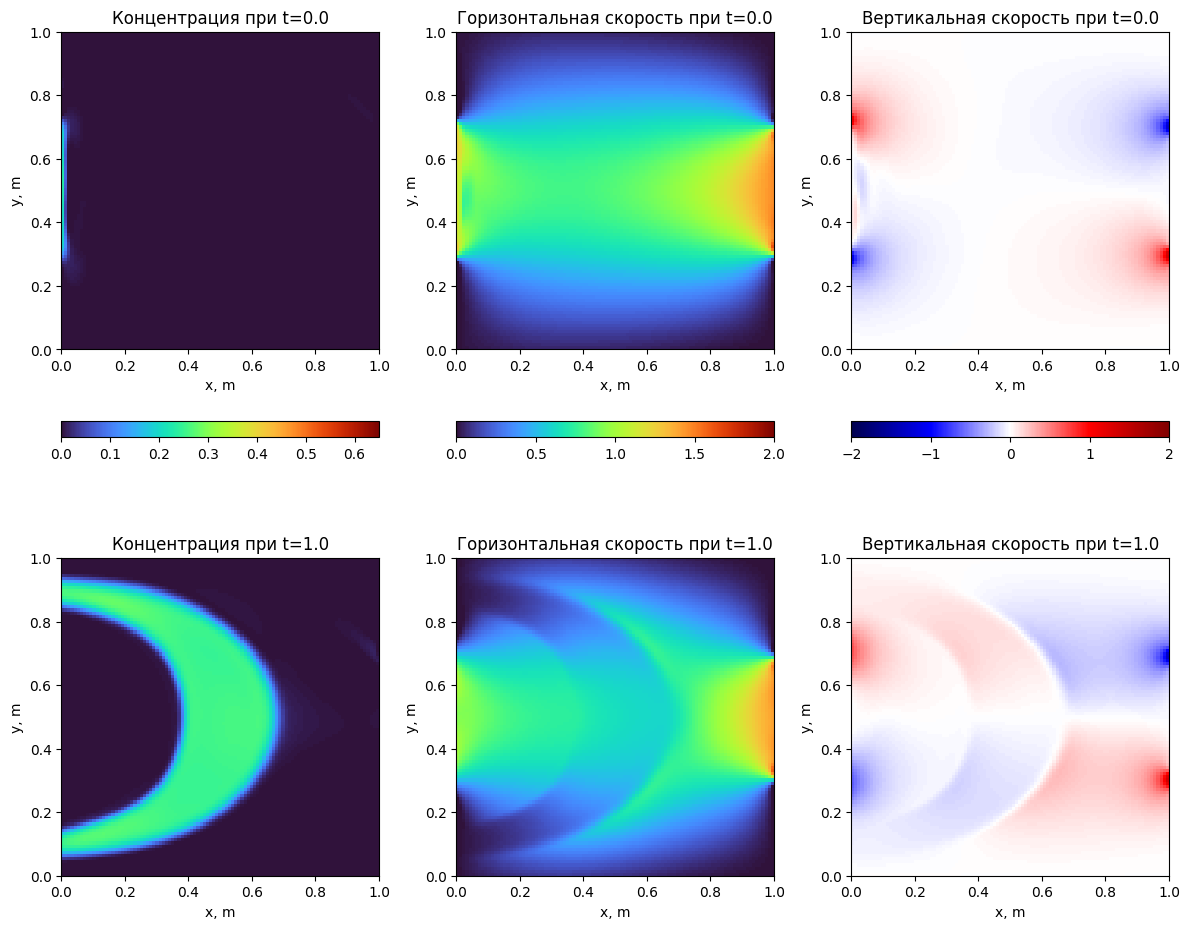

In [8]:
i = 0
j = -1
titles = [f'Концентрация при t={t[i]}', f'Горизонтальная скорость при t={t[i]}', f'Вертикальная скорость при t={t[i]}',
          f'Концентрация при t={t[j]}', f'Горизонтальная скорость при t={t[j]}', f'Вертикальная скорость при t={t[j]}']
plot_results(data=[c[i],ux[i],uy[i],c[j],ux[j],uy[j]],limits=[net.size[0], net.size[1], net.size[2], net.size[3]], t=[t[i], t[j]], title=titles, cmaps=['turbo','turbo','seismic','turbo','turbo','seismic'], lims=[0,net.cmax,0,2,-2,2])
# titles = [f'c at t={t[i]}',f'px at t={t[i]}',f'py at t={t[i]}',f'c at t={t[j]}',f'px at t={t[j]}',f'py at t={t[j]}']
# vis.plot_results(data=[c[i],px[i],py[i],c[j],px[j],py[j]],limits=[net.size[0], net.size[1], net.size[2], net.size[3]], t=[t[i], t[j]], title=titles, cmaps=['turbo','turbo','seismic','turbo','turbo','seismic'], lims=[0,net.cmax,-1,0,-1,1])
# titles = [f'conv at t={t[i]}',f'div at t={t[i]}',f'corr at t={t[i]}',f'conv at t={t[j]}',f'div at t={t[j]}',f'corr at t={t[j]}']
# vis.plot_results(data=[conv[i],div[i],corr[i],conv[j],div[j],corr[j]],limits=[net.size[0], net.size[1], net.size[2], net.size[3]], t=[t[i], t[j]], title=titles, cmaps=['seismic','seismic','seismic','seismic','seismic','seismic'], lims=[-2,2,-2,2,-1,1])
pass

In [9]:
# np.save('data/January_21/c_NN', c)
# np.save('data/January_19/ux_NN', ux)
# np.save('data/January_19/uy_NN', uy)

In [10]:
net.y_BC.shape

torch.Size([20480])

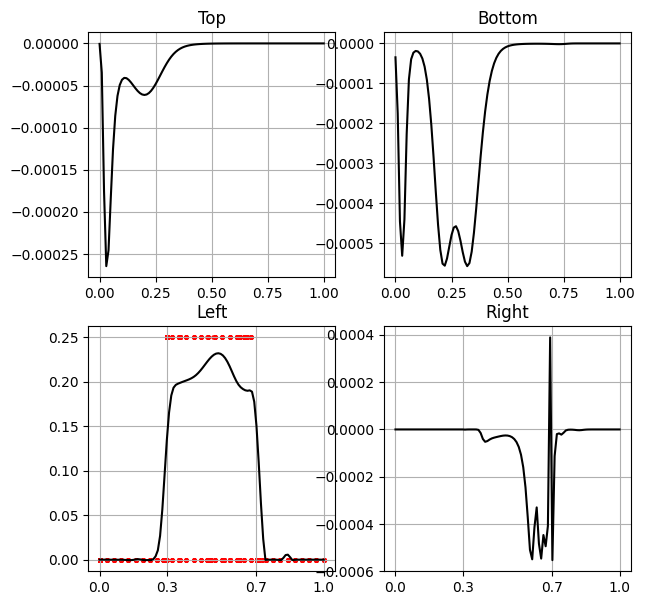

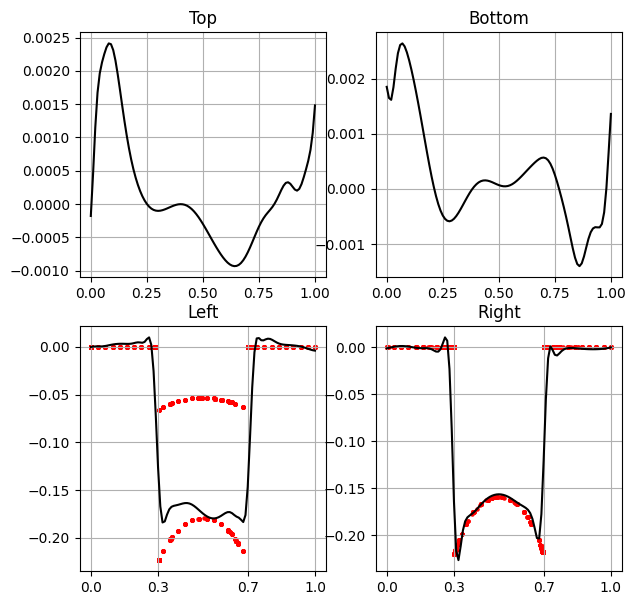

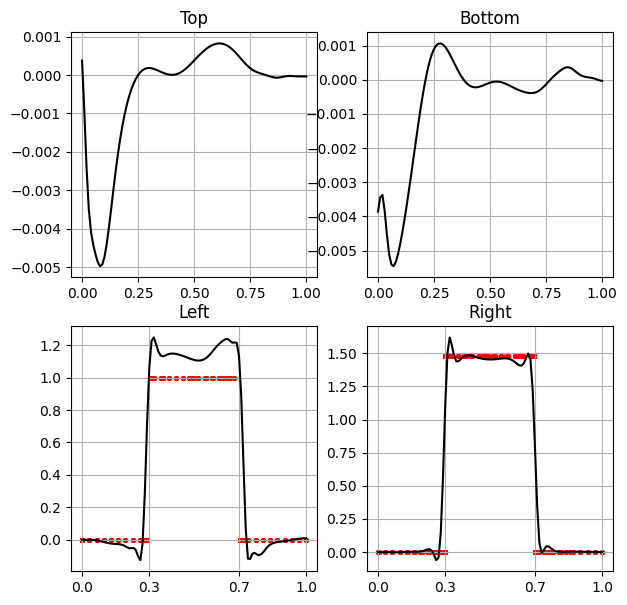

In [11]:
i = 0
N = int(net.N_BC2/4)
M = net.N_BC2
plot_BC(c[i], c[i], x, y)
plt.subplot(223)
plt.scatter(torch.cat((net.y_BC[2*N:3*N],net.y_BC[3*M:4*M])).data.cpu(), torch.cat((net.c[2*N:3*N],net.c[3*M:4*M])).data.cpu(), s=5, c='red')
plt.xticks([0, (np.max(y)-net.chi)/2, (np.max(y)+net.chi)/2 ,1])
plt.subplot(224)
plt.xticks([0, (np.max(y)-net.chi)/2, (np.max(y)+net.chi)/2 ,1])

plot_BC(py[i], px[i], x, y)
plt.subplot(223)
plt.scatter(torch.cat((net.y_BC[2*N:3*N],net.y_BC[3*M:4*M])).data.cpu(), torch.cat((net.p[2*N:3*N],net.p[3*M:4*M])).data.cpu(), s=5, c='red')
plt.xticks([0, (np.max(y)-net.chi)/2, (np.max(y)+net.chi)/2 ,1])
plt.subplot(224)
plt.scatter(torch.cat((net.y_BC[3*N:4*N],net.y_BC[4*M:])).data.cpu(), torch.cat((net.p[3*N:4*N], net.p[4*M:])).data.cpu(),label='right', s=5, c='red')
plt.xticks([0, (np.max(y)-net.chi)/2, (np.max(y)+net.chi)/2 ,1])

plot_BC(uy[i], ux[i], x, y)
plt.subplot(223)
plt.scatter(torch.cat((net.y_BC[2*N:3*N],net.y_BC[3*M:4*M])).data.cpu(), torch.cat((net.u[2*N:3*N],net.u[3*M:4*M])).data.cpu(), s=5, c='red')
plt.xticks([0, (np.max(y)-net.chi)/2, (np.max(y)+net.chi)/2 ,1])
plt.subplot(224)
plt.scatter(torch.cat((net.y_BC[3*N:4*N],net.y_BC[4*M:])).data.cpu(), torch.cat((net.u[3*N:4*N],net.u[4*M:])).data.cpu(),label='right', s=5, c='red')
plt.xticks([0, (np.max(y)-net.chi)/2, (np.max(y)+net.chi)/2 ,1])
pass

In [12]:
t_button = ipw.Dropdown(options=np.unique(net.t_PDE.data.cpu().numpy()),
                        value=0,
                        description='Number:',
                        disabled=False,
                        )
ipw.interact(check_PDE_points, t=t_button, net=ipw.fixed(net), Nx=ipw.fixed(Nx), Ny=ipw.fixed(Ny), eps=ipw.fixed(0),size=ipw.fixed(net.size))
pass

interactive(children=(Dropdown(description='Number:', options=(0.0, 0.0030312766, 0.0043670908, 0.046082187, 0…

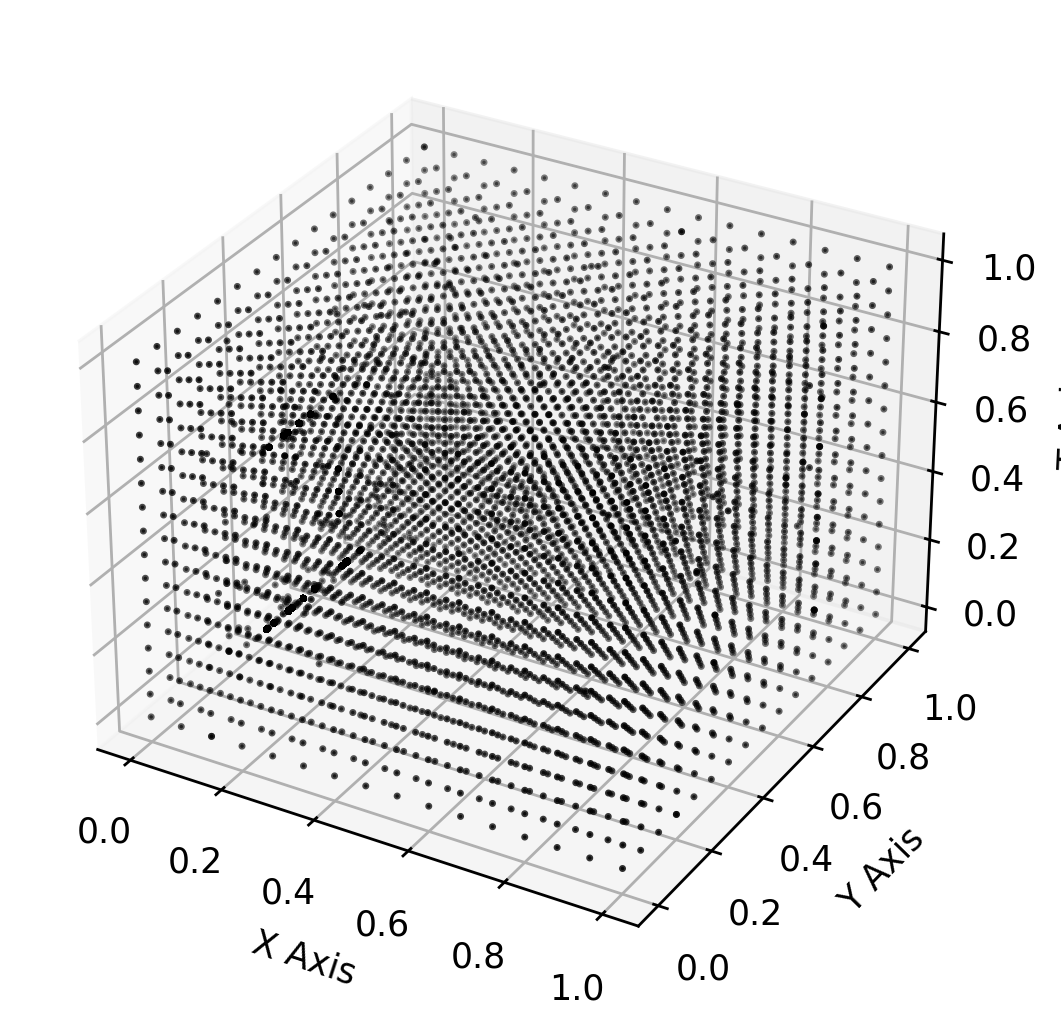

In [13]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(15,5),dpi=250)
ax = fig.add_subplot(111, projection='3d')
dots = ax.scatter(net.x_PDE.data.cpu(), net.y_PDE.data.cpu(), net.t_PDE.data.cpu(),c='black', s=1)
# fig.colorbar(dots)
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('T Axis')
pass

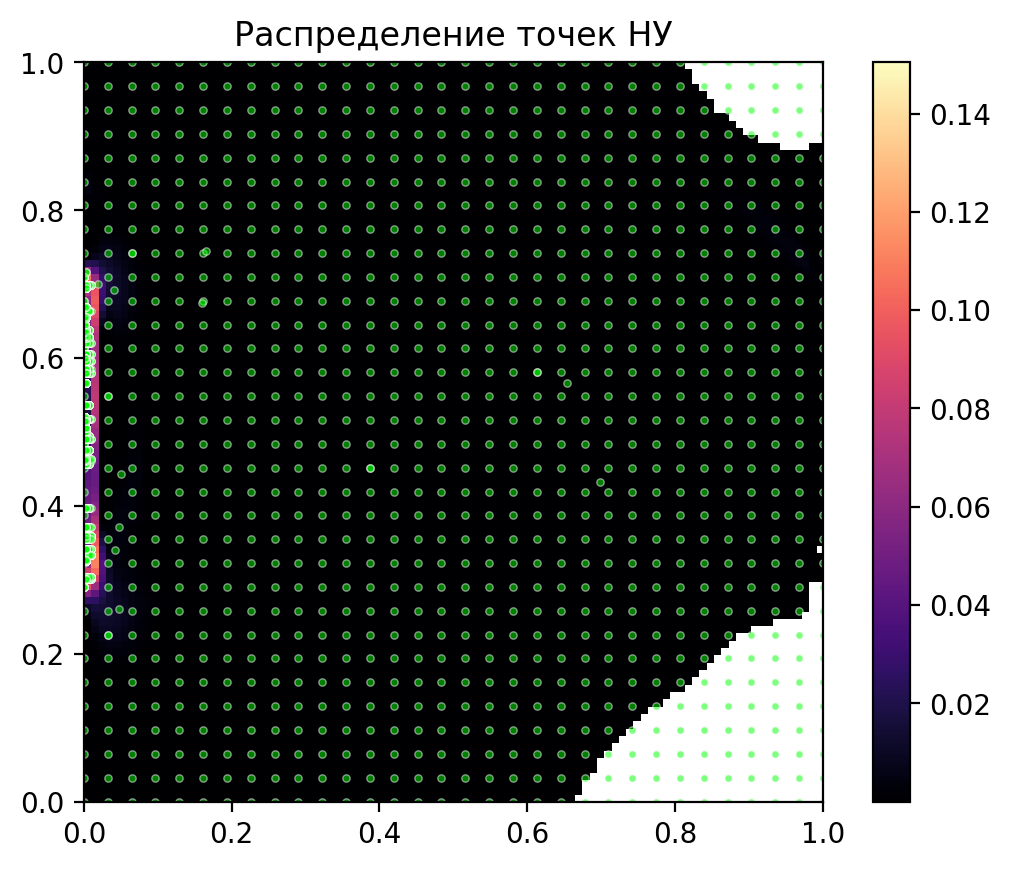

In [14]:
fig = plt.figure(dpi=200)
err = np.abs(c[0] - np.where(mesh_yx==0, net.c_cond[0], 0)*np.where(np.abs(mesh_xy - net.size[3]/2)<=net.chi/2, 1, 0))
plt.imshow(np.where(err-0>0, err, np.nan), cmap='magma', extent=[net.size[0],net.size[1],net.size[3],net.size[2]])
plt.colorbar()
plt.gca().invert_yaxis()
plt.scatter(net.x_IC.data.cpu().numpy(), net.y_IC.data.cpu().numpy(), alpha=0.5, c='lime', edgecolors='white', s=7, linewidths=0.5)
plt.title('Распределение точек НУ')
pass

In [15]:
# # # Create a 3D scatter plot
# fig = plt.figure(figsize=(15,5), dpi=250)
# ax = fig.add_subplot(111, projection='3d')
# # dots = ax.scatter(net.x_BC[net.N_BC2:].data.cpu(), net.y_BC[net.N_BC2:].data.cpu(), net.t_BC[net.N_BC2:].data.cpu(), alpha=0.5, c='lime', edgecolors='black', s=7, linewidths=0.5)
# dots = ax.scatter(net.x_BC[3*net.N_BC2:].data.cpu(), net.y_BC[3*net.N_BC2:].data.cpu(), net.t_BC[3*net.N_BC2:].data.cpu(), alpha=0.5, c='lime', edgecolors='black', s=7, linewidths=0.5)
# # fig.colorbar(dots)
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Y Axis')
# ax.set_zlabel('T Axis')
# pass

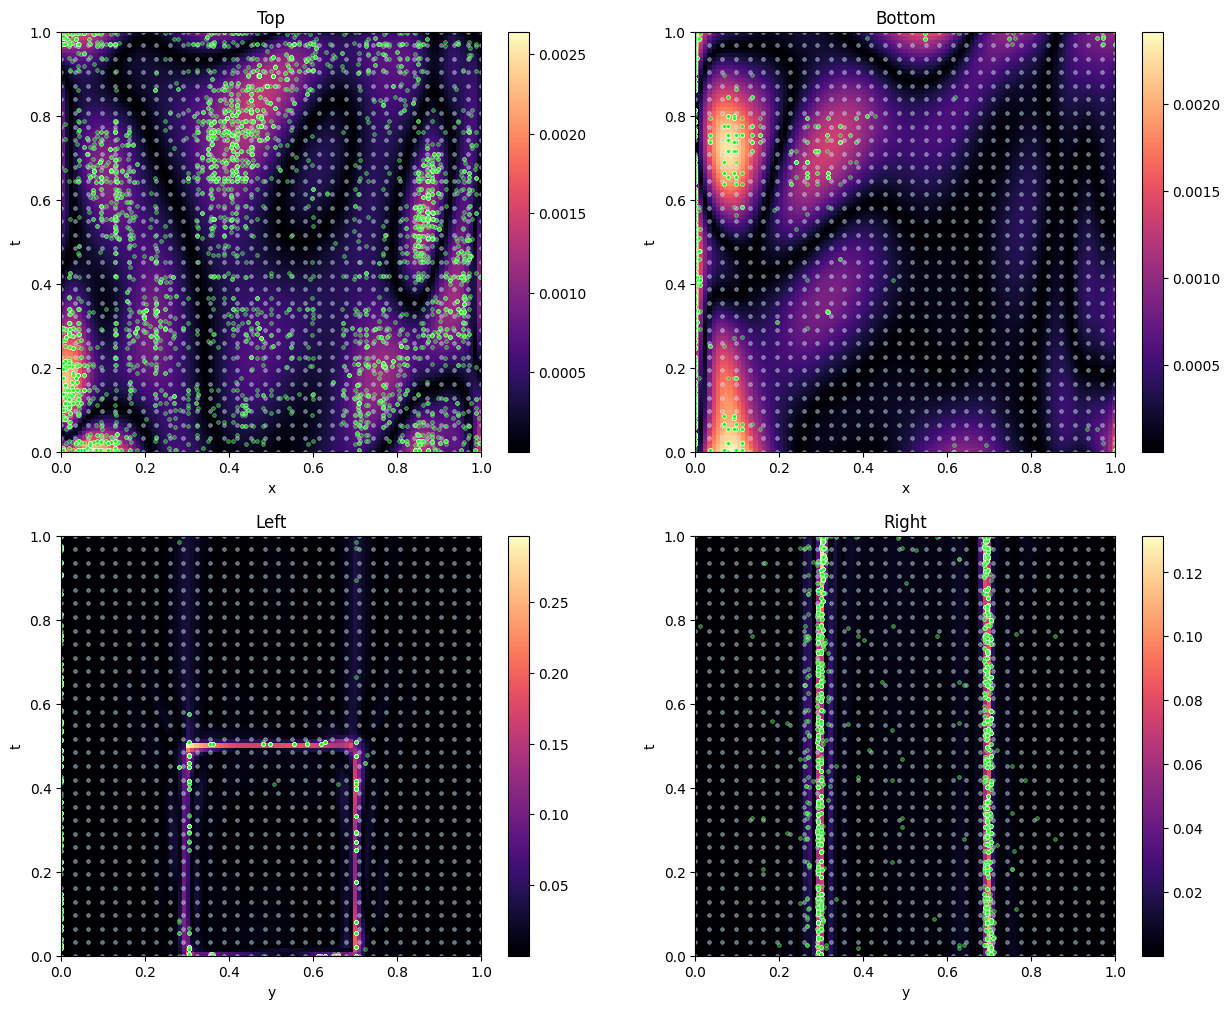

In [16]:
u_out = np.array(net.u_out.data.cpu())
plot_boundary_fields(net, mesh_yt, mesh_ty, px, py, c, u_out, True)
pass

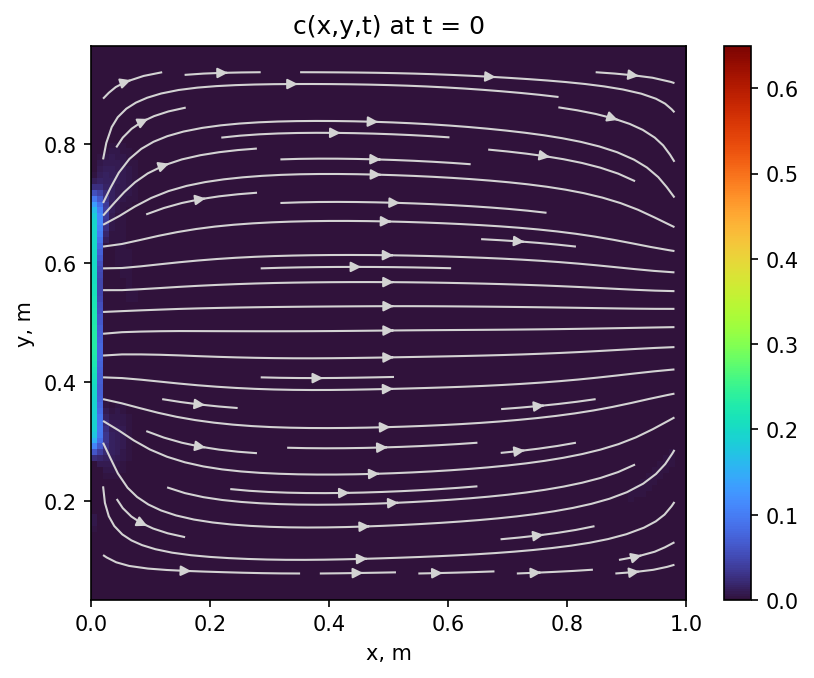

In [17]:
anim_result(c,
            net.size[5]/Nt,
            clims=[0,net.cmax],
            streamplot_data=[mesh_yx[2:-2,2:-2],mesh_xy[2:-2,2:-2],ux[:,2:-2,2:-2],uy[:,2:-2,2:-2]],
            name='gifk',
            title='c(x,y,t)',
            colour='turbo',
            path='gifs',
            savetogif=True,
            showMe=True,
            )